# CIFAR-10データセットを用いて画像分類してみる

## import

In [1]:
import os
import sys

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

sys.path.append('../src')
import utils

sys.path.append('./src')
from model import *

In [2]:
config = utils.readConfig('../config.json')
#raw_path = config['filepath']['output_dir'] + '/20211105_log_revise/01'
output_path = config['filepath']['output_dir'] + '/01'

utils.makeDirs(output_path, ['graph'])

## GPU or CPU 

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## set seed

In [4]:
# parserなどで指定
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

## Preprocessing

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(), #0〜255の整数値を0〜1の浮動小数点数型に変換する
    transforms.Normalize((0.5,), (0.5,)) #平均と標準偏差に0.5を指定することで、値の範囲を[-1, 1]にする
])

##　load datset

In [6]:
train_dataset = datasets.CIFAR10(root="./cifar_data", train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root="./cifar_data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


## dataloader 

In [7]:
train_dataloader  = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## functions to show an image

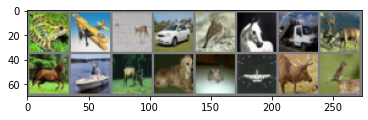

 frog plane  deer   car


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## initialize

In [9]:
model = Conv_Net()
model.to(device) #モデルを指定したデバイスに送る

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [10]:
model

Conv_Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## train

In [11]:
loss_metric = nn.MSELoss()

In [12]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = loss_metric(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 1.607
[2,  2000] loss: 1.345
[3,  2000] loss: 1.260
[4,  2000] loss: 1.223
[5,  2000] loss: 1.195
[6,  2000] loss: 1.171
[7,  2000] loss: 1.153
[8,  2000] loss: 1.151
[9,  2000] loss: 1.129
[10,  2000] loss: 1.122
Finished Training


## save

In [13]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

## test 

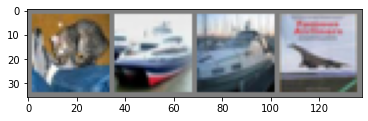

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car   car plane
Accuracy of the network on the 10000 test images: 58 %


In [14]:
dataiter = iter(validation_dataloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Conv_Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in validation_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in validation_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 68 %
Accuracy of  bird : 38 %
Accuracy of   cat : 39 %
Accuracy of  deer : 58 %
Accuracy of   dog : 51 %
Accuracy of  frog : 59 %
Accuracy of horse : 68 %
Accuracy of  ship : 65 %
Accuracy of truck : 72 %


In [16]:
net

Conv_Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)